# This code based on these codes.
https://www.kaggle.com/francksylla/titanic/titanic-machine-learning-from-disaster/code


In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

train_input = pd.read_csv("../input/train.csv", dtype={"Age": np.float64})
test_input = pd.read_csv("../input/test.csv", dtype={"Age": np.float64})

df = pd.concat([train_input, test_input], ignore_index=True)
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


[[<matplotlib.axes._subplots.AxesSubplot object at 0x2083AA70>


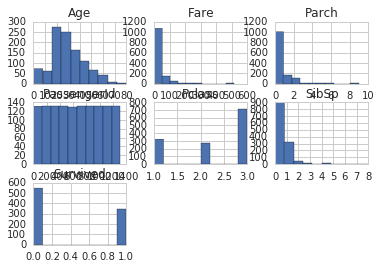

In [708]:
print(df.hist())

In [709]:
categorical_columns = ['Sex', 'Embarked']
numerical_columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
text_columns = ['Name', 'Ticket']

def category_to_numeric(df, column_name):
    for category in df[column_name].unique():
        category_column = column_name + '_' + str(category)
        if category_column in df.columns:
            df = df.drop(category_column, axis=1)
        if category_column not in numerical_columns:
            numerical_columns.append(category_column)
    df= pd.concat([df,pd.get_dummies(df[column_name], prefix=column_name)],axis=1)
    return df

[[<matplotlib.axes._subplots.AxesSubplot object at 0x2083EA90>


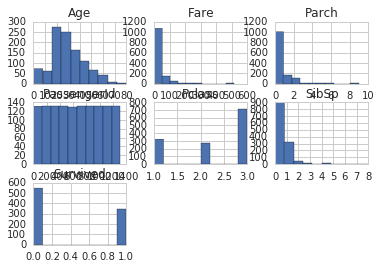

In [710]:
print(df.hist())

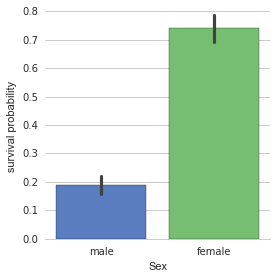

In [711]:
# Sex
import seaborn as sns
sns.set(style="whitegrid")

g = sns.factorplot(x="Sex", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

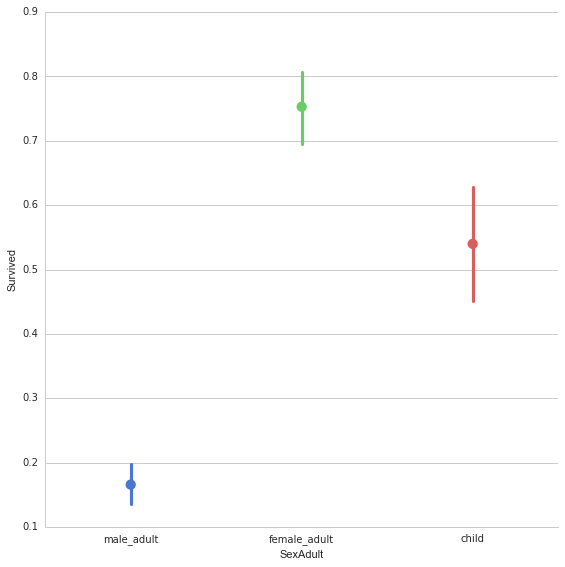

In [712]:
def get_sex_adult(row):
    age, sex = row
    if age < 18:
        return 'child'
    elif sex == 'female':
        return 'female_adult'
    else:
        return 'male_adult'

df['SexAdult'] = df[['Age', 'Sex']].apply(get_sex_adult, axis=1)
g = sns.factorplot(x="SexAdult", y="Survived", data=df, size=8, palette="muted")

if 'SexAdult' not in categorical_columns:
    categorical_columns.append('SexAdult')

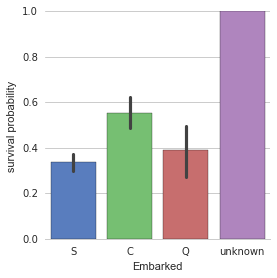

In [713]:
# Embarked
df['Embarked'] = df['Embarked'].fillna('unknown')
g = sns.factorplot(x="Embarked", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

if 'Embarked' not in categorical_columns:
    categorical_columns.append('Embarked')

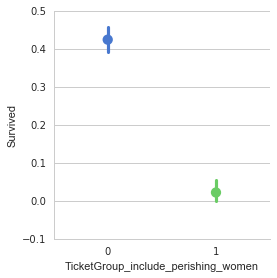

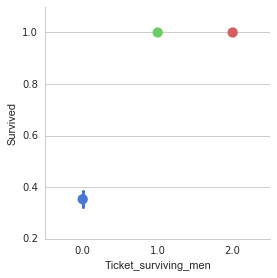

In [714]:
df_ticket = pd.DataFrame(df['Ticket'].value_counts())
df_ticket.rename(columns={'Ticket':'TicketMembers'}, inplace=True)

df_ticket['Ticket_perishing_women'] = df.Ticket[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_perishing_women'] = df_ticket['Ticket_perishing_women'].fillna(0)
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['Ticket_perishing_women'] > 0
df_ticket['TicketGroup_include_perishing_women'] = df_ticket['TicketGroup_include_perishing_women'].astype(int)

df_ticket['Ticket_surviving_men'] = df.Ticket[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_ticket['Ticket_surviving_men'] = df_ticket['Ticket_surviving_men'].fillna(0)
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['Ticket_surviving_men'] > 0
df_ticket['TicketGroup_include_surviving_men'] = df_ticket['TicketGroup_include_surviving_men'].astype(int)

df_ticket["TicketId"] = pd.Categorical.from_array(df_ticket.index).codes
df_ticket.loc[df_ticket[df_ticket['TicketMembers'] < 3].index, "TicketId"] = -1
df_ticket["TicketMembers_Simple"] = pd.cut(df_ticket['TicketMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'TicketGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_ticket, left_on="Ticket", right_index=True, how='left', sort=False)

if 'Ticket_perishing_women' not in numerical_columns:
    numerical_columns.append('Ticket_perishing_women')
if 'TicketGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_perishing_women')
if 'Ticket_surviving_men' not in numerical_columns:
    numerical_columns.append('Ticket_surviving_men')
if 'TicketGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('TicketGroup_include_surviving_men')
if 'TicketId' not in numerical_columns:
    numerical_columns.append('TicketId')
if 'TicketMembers' not in numerical_columns:
    numerical_columns.append('TicketMembers')
    
g = sns.factorplot(x="TicketGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="Ticket_surviving_men", y="Survived", data=df, size=4, palette="muted")

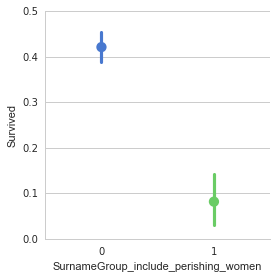

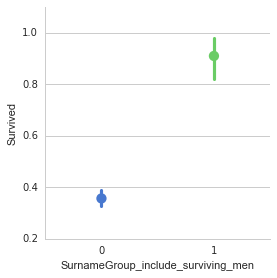

In [715]:
# surname
df['surname'] = df['Name'].apply(lambda x: x.split(',')[0].lower())
df_surname = pd.DataFrame(df['surname'].value_counts())
df_surname.rename(columns={'surname':'SurnameMembers'}, inplace=True)

df_surname['Surname_perishing_women'] = df.surname[(df.SexAdult == 'female_adult')
                                               & (df.Survived == 0.0)
                                               & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_perishing_women'] = df_surname['Surname_perishing_women'].fillna(0)
df_surname['SurnameGroup_include_perishing_women'] = df_surname['Surname_perishing_women'] > 0
df_surname['SurnameGroup_include_perishing_women'] = df_surname['SurnameGroup_include_perishing_women'].astype(int)

df_surname['Surname_surviving_men'] = df.surname[(df.SexAdult == 'male_adult')
                                              & (df.Survived == 1.0)
                                              & ((df.Parch > 0) | (df.SibSp > 0))].value_counts()
df_surname['Surname_surviving_men'] = df_surname['Surname_surviving_men'].fillna(0)
df_surname['SurnameGroup_include_surviving_men'] = df_surname['Surname_surviving_men'] > 0
df_surname['SurnameGroup_include_surviving_men'] = df_surname['SurnameGroup_include_surviving_men'].astype(int)

df_surname["SurnameId"] = pd.Categorical.from_array(df_surname.index).codes
df_surname.loc[df_surname[df_surname['SurnameMembers'] < 3].index, "SurnameId"] = -1
df_surname["SurnameMembers_Simple"] = pd.cut(df_surname['SurnameMembers'], bins=[0,1,4,20], labels=[0,1,2])
if 'SurnameGroup_include_perishing_women' not in df.columns:
    df = pd.merge(df, df_surname, left_on="surname", right_index=True, how='left', sort=False)


if 'Surname_perishing_women' not in numerical_columns:
    numerical_columns.append('Surname_perishing_women')
if 'SurnameGroup_include_perishing_women' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_perishing_women')
if 'Surname_surviving_men' not in numerical_columns:
    numerical_columns.append('Surname_surviving_men')
if 'SurnameGroup_include_surviving_men' not in numerical_columns:
    numerical_columns.append('SurnameGroup_include_surviving_men')
if 'SurnameId' not in numerical_columns:
    numerical_columns.append('SurnameId')
if 'SurnameMembers' not in numerical_columns:
    numerical_columns.append('SurnameMembers')
    
g = sns.factorplot(x="SurnameGroup_include_perishing_women", y="Survived", data=df, size=4, palette="muted")
g = sns.factorplot(x="SurnameGroup_include_surviving_men", y="Survived", data=df, size=4, palette="muted")

In [716]:
# title
import re
df['Name_title'] = df['Name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1))
df.loc[df[df['Name_title'] == 'Ms'].index, 'Name_title'] = 'Miss'
print(df['Name_title'].unique())
if 'Name_title' not in categorical_columns:
    categorical_columns.append('Name_title')

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Major' 'Lady' 'Sir'
 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']


[[<matplotlib.axes._subplots.AxesSubplot object at 0x22363990>


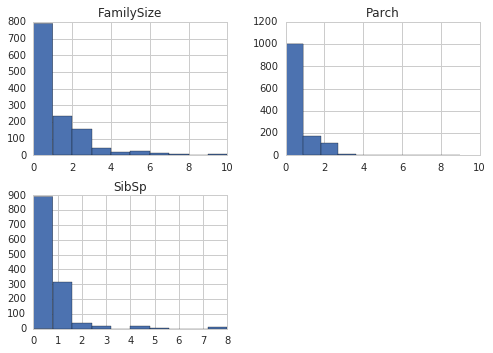

In [717]:
# FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch']
if 'FamilySize' not in numerical_columns:
    numerical_columns.append('FamilySize')
print(df[['SibSp', 'Parch', 'FamilySize']].hist())

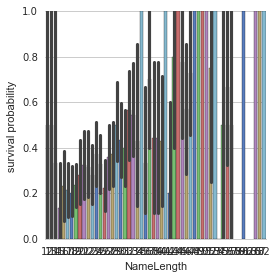

In [718]:
# Name Length?
df['NameLength'] = df["Name"].apply(lambda x: len(x))
if 'NameLength' not in numerical_columns:
    numerical_columns.append('NameLength')
g = sns.factorplot(x="NameLength", y="Survived", data=df, size=4, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

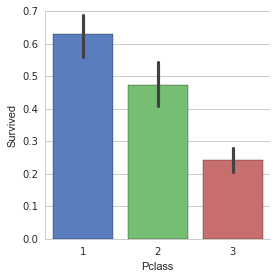

In [719]:
g = sns.factorplot(x="Pclass", y="Survived", data=df, size=4, kind="bar", palette="muted")

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49' 'F4'
 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77' 'E67'
 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106' 'C65'
 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91' 'E40'
 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34' 'C104'
 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79' 'E25'
 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68' 'A10'
 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58' 'C126'
 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90' 'C45'
 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6' 'B82 B84'
 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50' 'B42' 'C148'
 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

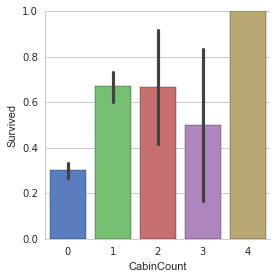

In [720]:
# cabin
print(df['Cabin'].unique())

# https://www.kaggle.com/c/titanic/prospector#1326
def get_cabin_location(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('\d+', cabin)
    if cabin_search_result:
        type_code = np.int64(cabin_search_result.group(0))
        if type_code % 2 == 0:
            return 'port'
        else:
            return 'starboard'
    return 'unknown'

def get_cabin_deck(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[A-z]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0)
    return 'unknown'

def get_cabin_count(cabin):
    cabin_search_result = re.findall('([A-z]\d+)', cabin)
    if cabin_search_result:
        return len(cabin_search_result)
    return 0

df['CabinLocation'] = df['Cabin'].fillna(' ').apply(get_cabin_location)
df['CabinDeck'] = df['Cabin'].fillna(' ').apply(get_cabin_deck)
df['CabinCount'] = df['Cabin'].fillna(' ').apply(get_cabin_count)

g = sns.factorplot(x="CabinCount", y="Survived", data=df, size=4, kind="bar", palette="muted")

if 'CabinLocation' not in categorical_columns:
    categorical_columns.append('CabinLocation')
if 'CabinDeck' not in categorical_columns:
    categorical_columns.append('CabinDeck')
if 'CabinCount' not in numerical_columns:
    numerical_columns.append('CabinCount')

count    1309.000000
mean       33.295479
std        51.738879
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
Axes(0.125,0.125;0.775x0.775)


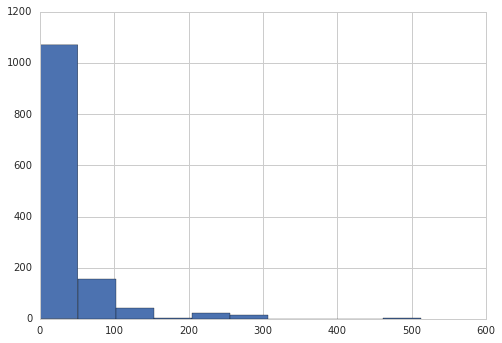

In [721]:
# Fare
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
print(df['Fare'].describe())
print(df['Fare'].hist())

   Pclass     Fare  TicketMembers
0       3   7.2500              1
1       1  71.2833              2
2       3   7.9250              1
3       1  53.1000              2
4       3   8.0500              1
Axes(0.125,0.125;0.775x0.775)


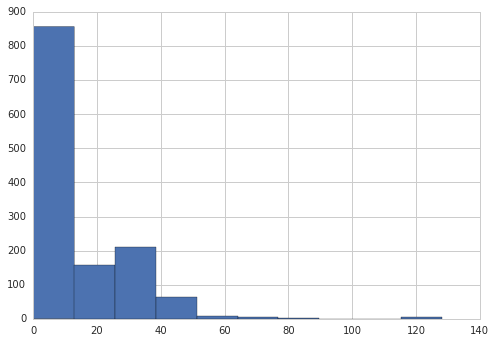

In [722]:
df['TicketMembers'] = df['TicketMembers'].fillna(0)
print(df.head()[['Pclass','Fare', 'TicketMembers']])
df['Fare_per_ticket_member'] = df['Fare'] / (df['TicketMembers'])
print(df['Fare_per_ticket_member'].hist())

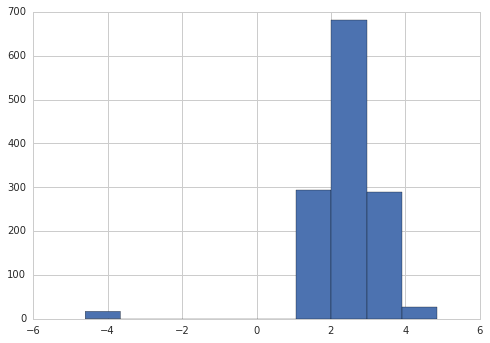

In [723]:
# convert to normally distributed
from math import log
df['Fare_per_ticket_member'].apply(lambda x: log(x + 0.01)).hist()

In [724]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare'].describe()

very_small_val = 0.01
df['Fare_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_standard_score_with_Pclass')

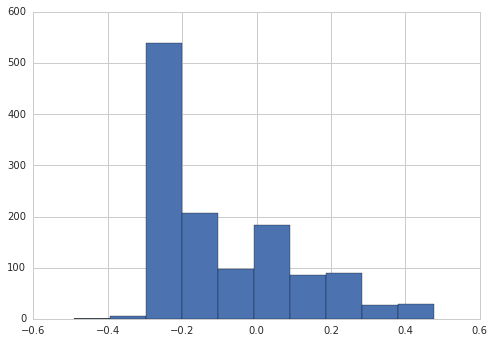

In [725]:
df[(df['Fare_standard_score_with_Pclass'] >= -0.5) & (df['Fare_standard_score_with_Pclass'] <= 0.5)]['Fare_standard_score_with_Pclass'].hist()

In [726]:
from math import log

class_fare = pd.DataFrame(columns=['count','mean','std','min','25%','50%','75%','max'])
class_fare.loc[1,:] = df[df['Pclass'] == 1]['Fare_per_ticket_member'].describe()
class_fare.loc[2,:] = df[df['Pclass'] == 2]['Fare_per_ticket_member'].describe()
class_fare.loc[3,:] = df[df['Pclass'] == 3]['Fare_per_ticket_member'].describe()

very_small_val = 0.01
df['Fare_per_ticket_member_standard_score_with_Pclass'] = df.apply(lambda row: (log(row['Fare_per_ticket_member'] + very_small_val) - log(class_fare.loc[row['Pclass'], 'mean'] + very_small_val)) / log(class_fare.loc[row['Pclass'], 'std'] + very_small_val), axis=1)
if 'Fare_per_ticket_member_standard_score_with_Pclass' not in numerical_columns:
    numerical_columns.append('Fare_per_ticket_member_standard_score_with_Pclass')

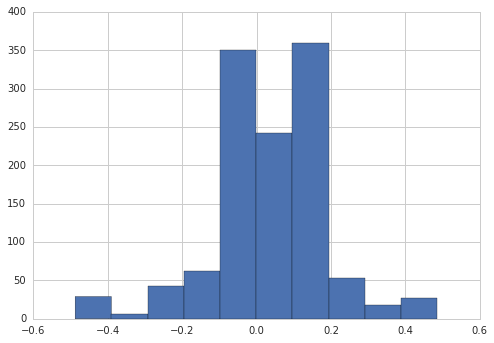

In [727]:
df[(df['Fare_per_ticket_member_standard_score_with_Pclass'] >= -0.5) & (df['Fare_per_ticket_member_standard_score_with_Pclass'] <= 0.5)]['Fare_per_ticket_member_standard_score_with_Pclass'].hist()

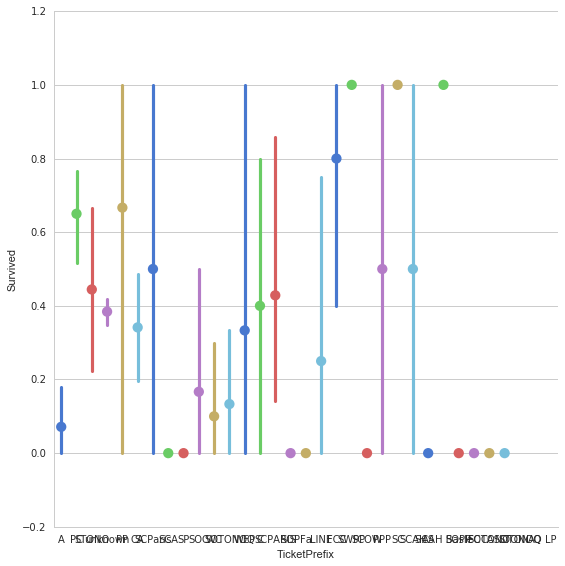

In [728]:
# https://www.kaggle.com/c/titanic/forums/t/11127/do-ticket-numbers-mean-anything
#print(df["Ticket"])
#print(df["Ticket"].value_counts())

def get_ticket_prefix(cabin):
    # The cabin info consists of a letter (corresponding to a deck) 
    # and a cabin number, which is odd for cabins on the starboard side and even for the port.
    cabin_search_result = re.search('[^\d]+', cabin)
    if cabin_search_result:
        return cabin_search_result.group(0).replace('/', '').replace('.', '').strip()
    return 'unknown'

df['TicketPrefix'] = df['Ticket'].apply(get_ticket_prefix)
g = sns.factorplot(x="TicketPrefix", y="Survived", data=df, size=8, palette="muted")

if 'TicketPrefix' not in categorical_columns:
    categorical_columns.append('TicketPrefix')

In [729]:
for col in categorical_columns:
    df = category_to_numeric(df, col)

In [741]:
# age prediction
from sklearn.ensemble import ExtraTreesRegressor

age_prediction_features = ['Fare', 'Fare_standard_score_with_Pclass',
                           #'Fare_per_ticket_member', 'Fare_per_ticket_member_standard_score_with_Pclass',
                           'Parch', 'Pclass', 'SibSp', 'Sex_female', 'Sex_male', 'FamilySize',
                           'NameLength', 'TicketMembers', 'TicketId', 
                           'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
                           'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
                           'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 
                           'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
                           'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
                           'CabinLocation_unknown', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_unknown', 
                           'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T']
age_prediction_tree_regressor = ExtraTreesRegressor(n_estimators=200)
age_X_train = df[age_prediction_features][df['Age'].notnull()]
age_Y_train = df['Age'][df['Age'].notnull()]
age_prediction_tree_regressor.fit(age_X_train, np.ravel(age_Y_train))

# TODO fill only isnull values

df['Age_pred'] = age_prediction_tree_regressor.predict(df[age_prediction_features])
if 'Age_pred' not in numerical_columns:
    numerical_columns.append('Age_pred')

# TODO add ageGroup

In [746]:
# Frugal_First_Class_Single_Man
# midle age first class single man with large discounted and unknown prefixed ticket and without cabin.
print("died", df[(df['Survived'] == 0) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])
print("survived", df[(df['Survived'] == 1) & (df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)
        ])

('died', Empty DataFrame
Columns: [Age, Cabin, Embarked, Fare, Name, Parch, PassengerId, Pclass, Sex, SibSp, Survived, Ticket, SexAdult, TicketMembers, Ticket_perishing_women, TicketGroup_include_perishing_women, Ticket_surviving_men, TicketGroup_include_surviving_men, TicketId, TicketMembers_Simple, surname, SurnameMembers, Surname_perishing_women, SurnameGroup_include_perishing_women, Surname_surviving_men, SurnameGroup_include_surviving_men, SurnameId, SurnameMembers_Simple, Name_title, FamilySize, NameLength, CabinLocation, CabinDeck, CabinCount, Fare_per_ticket_member, Fare_standard_score_with_Pclass, Fare_per_ticket_member_standard_score_with_Pclass, TicketPrefix, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S, Embarked_unknown, SexAdult_child, SexAdult_female_adult, SexAdult_male_adult, Name_title_Capt, Name_title_Col, Name_title_Countess, Name_title_Don, Name_title_Dona, Name_title_Dr, Name_title_Jonkheer, Name_title_Lady, Name_title_Major, Name_title_Master, Name_tit

In [747]:
df['Frugal_First_Class_Single_Man'] = 0
df.loc[df[(df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)]['Frugal_First_Class_Single_Man'].index, 'Frugal_First_Class_Single_Man'] = 1
print(df[(df['Sex'] == 'male') 
         & (df['Pclass'] == 1) 
         & (df['Age_pred'] <= 45) 
         & (df['Fare'] > 0)
         & (df['Fare_standard_score_with_Pclass'] < -0.25)
         & (df['TicketPrefix_unknown'] == 1)
         & (df['TicketMembers_Simple'] == 0)
         & (df['CabinCount'] == 0)]['Frugal_First_Class_Single_Man'])
if 'Frugal_First_Class_Single_Man' not in numerical_columns:
    numerical_columns.append('Frugal_First_Class_Single_Man')

187     1
447     1
507     1
604     1
985     1
1035    1
Name: Frugal_First_Class_Single_Man, dtype: int64


In [733]:
# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

train = df[0:891].fillna(0).copy()
target = train["Survived"].values

selector = SelectKBest(f_classif, k=len(numerical_columns))
selector.fit(train[numerical_columns], target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]
print("Features importance :")
for f in range(len(scores)):
    print("%0.2f %s" % (scores[indices[f]],numerical_columns[indices[f]]))

Features importance :
nan Frugal_First_Class_Single_Man
nan TicketPrefix_AQ
nan TicketPrefix_STONOQ
nan Name_title_Dona
nan TicketPrefix_LP
70.61 Name_title_Mr
68.85 Sex_male
68.85 Sex_female
64.90 SexAdult_male_adult
53.23 SexAdult_female_adult
24.68 Name_title_Mrs
24.60 Pclass
23.69 NameLength
23.35 Name_title_Miss
21.51 CabinDeck_unknown
21.46 CabinLocation_unknown
17.23 CabinCount
17.00 TicketGroup_include_surviving_men
16.30 Ticket_surviving_men
14.21 Fare
13.54 TicketGroup_include_perishing_women
13.22 CabinLocation_starboard
13.04 SurnameGroup_include_surviving_men
12.71 Surname_surviving_men
10.83 Ticket_perishing_women
10.36 SurnameGroup_include_perishing_women
9.04 Surname_perishing_women
6.84 CabinDeck_B
6.73 CabinLocation_port
6.36 Embarked_C
5.52 Embarked_S
5.21 CabinDeck_D
4.98 TicketPrefix_PC
4.88 CabinDeck_E
3.59 SexAdult_child
3.38 Fare_standard_score_with_Pclass
3.27 TicketPrefix_A
3.22 CabinDeck_C
1.96 Name_title_Master
1.83 Parch
1.35 TicketPrefix_SOTONOQ
1.28 Name_

In [734]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

random_forest = RandomForestClassifier(n_estimators=1000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[numerical_columns], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[numerical_columns], target)
score = random_forest.score(train[numerical_columns], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(numerical_columns)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, numerical_columns[indices[f]]))

Accuracy: 89.787 (+/- 1.04) [Random Forest Cross Validation]
Accuracy: 96.745             [Random Forest full test]
1. feature 32 (5.661192) Name_title_Mr
2. feature 23 (5.640016) Sex_male
3. feature 19 (5.368416) NameLength
4. feature 94 (5.003310) Age_pred
5. feature 24 (4.938007) Sex_female
6. feature 5 (4.851631) Fare
7. feature 21 (4.358717) Fare_standard_score_with_Pclass
8. feature 29 (4.291922) SexAdult_male_adult
9. feature 6 (3.882210) Ticket_perishing_women
10. feature 7 (3.846998) TicketGroup_include_perishing_women
11. feature 2 (3.817447) Age
12. feature 30 (3.792725) SexAdult_female_adult
13. feature 22 (3.643060) Fare_per_ticket_member_standard_score_with_Pclass
14. feature 12 (3.538373) Surname_perishing_women
15. feature 13 (3.325617) SurnameGroup_include_perishing_women
16. feature 1 (3.204634) Pclass
17. feature 9 (2.624802) TicketGroup_include_surviving_men
18. feature 8 (2.475938) Ticket_surviving_men
19. feature 11 (2.203035) TicketMembers
20. feature 33 (1.91100

In [749]:
# select specidic features
features = ['Sex_female','Sex_male','Age_pred','SexAdult_male_adult','SexAdult_female_adult', 'SexAdult_child',
            'Pclass', 'TicketId','NameLength', 'SibSp', 'Parch', 
            'Fare_standard_score_with_Pclass', 'Fare_per_ticket_member_standard_score_with_Pclass',
            'FamilySize', 'SurnameMembers', 'TicketMembers', 'SurnameMembers_Simple', 'TicketMembers_Simple',
            'TicketPrefix_unknown', 'TicketPrefix_SWPP', 'TicketPrefix_PC', 'TicketPrefix_PC',
            'TicketGroup_include_perishing_women','TicketGroup_include_surviving_men',
            'SurnameGroup_include_perishing_women','SurnameGroup_include_surviving_men',
            'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_unknown', 
            'Name_title_Mr', 'Name_title_Mrs', 'Name_title_Miss', 'Name_title_Master', 
            'Name_title_Don', 'Name_title_Rev', 'Name_title_Dr', 'Name_title_Mme', 
            'Name_title_Major', 'Name_title_Lady', 'Name_title_Sir', 'Name_title_Mlle', 'Name_title_Col', 
            'Name_title_Capt', 'Name_title_Countess', 'Name_title_Jonkheer', 
            'CabinLocation_unknown', 'CabinLocation_starboard', 'CabinLocation_port', 'CabinDeck_unknown', 
            'CabinDeck_C', 'CabinDeck_E', 'CabinDeck_G', 'CabinDeck_D', 'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_F', 'CabinDeck_T',
            'Frugal_First_Class_Single_Man'
           ]

random_forest = RandomForestClassifier(n_estimators=1000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, train[features], target, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(train[features], target)
score = random_forest.score(train[features], target)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 89.562 (+/- 1.20) [Random Forest Cross Validation]
Accuracy: 95.847             [Random Forest full test]
1. feature 9 (7.203672) NameLength
2. feature 3 (6.667151) Age_pred
3. feature 23 (6.623675) TicketGroup_include_perishing_women
4. feature 2 (6.145676) Sex_male
5. feature 25 (6.037999) SurnameGroup_include_perishing_women
6. feature 1 (5.475172) Sex_female
7. feature 12 (5.444088) Fare_standard_score_with_Pclass
8. feature 13 (5.228353) Fare_per_ticket_member_standard_score_with_Pclass
9. feature 7 (4.968308) Pclass
10. feature 31 (4.948110) Name_title_Mr
11. feature 4 (4.578591) SexAdult_male_adult
12. feature 24 (4.075973) TicketGroup_include_surviving_men
13. feature 5 (3.446933) SexAdult_female_adult
14. feature 26 (2.416197) SurnameGroup_include_surviving_men
15. feature 16 (2.384774) TicketMembers
16. feature 14 (1.954470) FamilySize
17. feature 18 (1.922967) TicketMembers_Simple
18. feature 15 (1.759402) SurnameMembers
19. feature 32 (1.669698) Name_title_Mrs
20.

In [750]:
# analyze failed.
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train, target, test_size=0.2, random_state=42)
random_forest = RandomForestClassifier(n_estimators=3000, min_samples_split=4, class_weight={0:0.745, 1:0.255})
kfold = cross_validation.KFold(X_train.shape[0], n_folds=3, random_state=42)

scores = cross_validation.cross_val_score(random_forest, X_train[features], y_train, cv=kfold)
print("Accuracy: %0.3f (+/- %0.2f) [%s]" % (scores.mean() * 100, scores.std() * 100, 'Random Forest Cross Validation'))

random_forest.fit(X_train[features], y_train)
score = random_forest.score(X_test[features], y_test)
print("Accuracy: %0.3f             [%s]" % (score * 100, 'Random Forest full test'))
pred_test = random_forest.predict(X_test[features])

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(features)):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f] + 1, importances[indices[f]] * 100, features[indices[f]]))

Accuracy: 89.048 (+/- 1.55) [Random Forest Cross Validation]
Accuracy: 91.061             [Random Forest full test]
1. feature 3 (6.811368) Age_pred
2. feature 9 (6.749230) NameLength
3. feature 25 (5.884439) SurnameGroup_include_perishing_women
4. feature 23 (5.772158) TicketGroup_include_perishing_women
5. feature 2 (5.731434) Sex_male
6. feature 12 (5.687839) Fare_standard_score_with_Pclass
7. feature 1 (5.429627) Sex_female
8. feature 31 (5.205856) Name_title_Mr
9. feature 7 (5.175047) Pclass
10. feature 13 (5.154363) Fare_per_ticket_member_standard_score_with_Pclass
11. feature 4 (4.572953) SexAdult_male_adult
12. feature 24 (3.778652) TicketGroup_include_surviving_men
13. feature 5 (3.728851) SexAdult_female_adult
14. feature 26 (2.500729) SurnameGroup_include_surviving_men
15. feature 32 (2.493268) Name_title_Mrs
16. feature 16 (2.467086) TicketMembers
17. feature 18 (1.985242) TicketMembers_Simple
18. feature 15 (1.952107) SurnameMembers
19. feature 14 (1.923444) FamilySize
20.

In [751]:
test = df[891:].copy()
random_forest.fit(train[features], target)
predictions = random_forest.predict(test[features])

In [752]:
PassengerId = np.array(test["PassengerId"]).astype(int)
submit_df = pd.DataFrame(predictions, PassengerId, columns = ['Survived']).astype(int)
submit_df.to_csv('titanic.csv', index_label=['PassengerId'])

In [753]:
print(submit_df.loc[[986, 1093, 1236, 1259], :])
print(test.loc[[986, 1093, 1236, 1259], :])

      Survived
986          0
1093         1
1236         1
1259         1
       Age    Cabin Embarked      Fare  \
986   25.0      NaN        S    7.7958   
1093  47.0  C62 C64        C  227.5250   
1236  16.0      NaN        S    7.6500   
1259  45.0      NaN        C   59.4000   

                                         Name  Parch  PassengerId  Pclass  \
986                Tenglin, Mr. Gunnar Isidor      0          987       3   
1093                   Astor, Col. John Jacob      0         1094       1   
1236              Abelseth, Miss. Karen Marie      0         1237       3   
1259  Gibson, Mrs. Leonard (Pauline C Boeson)      1         1260       1   

         Sex  SibSp  Survived    Ticket      SexAdult  TicketMembers  \
986     male      0       NaN    350033    male_adult              1   
1093    male      1       NaN  PC 17757    male_adult              5   
1236  female      0       NaN    348125         child              1   
1259  female      0       NaN    112378 

In [754]:
print(df[(df['Name_title_Col'] == 1) & (df['Survived'] == 1)])

      Age Cabin Embarked  Fare                                 Name  Parch  \
647  56.0   A26        C  35.5  Simonius-Blumer, Col. Oberst Alfons      0   

     PassengerId  Pclass   Sex  SibSp  Survived Ticket    SexAdult  \
647          648       1  male      0       1.0  13213  male_adult   

     TicketMembers  Ticket_perishing_women  \
647              1                     0.0   

     TicketGroup_include_perishing_women  Ticket_surviving_men  \
647                                    0                   0.0   

     TicketGroup_include_surviving_men  TicketId  TicketMembers_Simple  \
647                                  0        -1                     0   

             surname  SurnameMembers  Surname_perishing_women  \
647  simonius-blumer               1                      0.0   

     SurnameGroup_include_perishing_women  Surname_surviving_men  \
647                                     0                    0.0   

     SurnameGroup_include_surviving_men  SurnameId  Surname